# Component 1: Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

titanic = pd.read_csv('train.csv')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are 12 columns in total. The columns 'Age', 'Embarked', and 'Cabin' have some missing 
values. There are a mix of numerical and object data types.

In [2]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The features 'PassengerID', 'Name', 'Ticket', and 'Cabin' do not seem like they
will be of importance so they will be removed. Cabins on higher decks may indicate a higher likelihood of survival but this will likely be reflected in the fare price column which has easier to handle numerical data.

In [3]:
titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

The data table is rearranged to have numerical values before categorical.

In [4]:
numerical = ['Age', 'SibSp', 'Parch', 'Fare']
categorical = ['Sex', 'Pclass', 'Embarked', 'Survived']
titanic = titanic[numerical + categorical]
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Sex         891 non-null object
Pclass      891 non-null int64
Embarked    889 non-null object
Survived    891 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


## Missing Values:

There are missing values for the 'Age' and 'Embarked' columns. This will need to be dealt with before plotting and learning takes place.

In [5]:
# Finds the number of missing values for each column
missing_value_count_per_column = (titanic.isnull().sum())

# Prints the number of missing values for columns with missing values
print(missing_value_count_per_column[missing_value_count_per_column > 0])

Age         177
Embarked      2
dtype: int64


In [6]:
# Calculates the percentage of rows that have a missing value in the 'Age' column
age_percentage = round(missing_value_count_per_column[0]/titanic.shape[0], 3)
embarked_percentage = round(missing_value_count_per_column[6]/titanic.shape[0], 3)
print(age_percentage, embarked_percentage)

0.199 0.002


Only 20% of the rows in the 'Age' column and less than 1% of values in the 'Embarked' column are missing values therfore, simply dropping the columns with missing values would likely yield poor results for classification as we would lose lots of valuable information. 80% of rows still have a value for 'Age' and nearly all rows have a value for 'Embarked'.

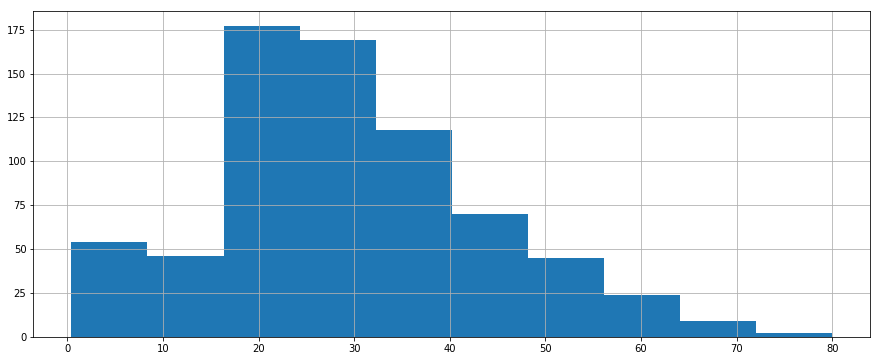

In [7]:
histogram = titanic['Age'].hist(figsize=(15,6));

The histogram for the 'Age' data is skewed right. This suggests that the mean average may not be a suitable value to replace missing values with. Instead the median will be used.

In [8]:
print("Age Mean: %s" %titanic['Age'].mean())
print("Age Median: %s" %titanic['Age'].median())

Age Mean: 29.69911764705882
Age Median: 28.0


However, there is little difference so it will likely not have a great effect.

In [9]:
# Creates an imputer that replaces NaN values with the median of the column values
numeric_imputer = SimpleImputer(strategy = 'median')

# Creates an imputer that replaces NaN values with the most frequent of the column values,
# this approach is more suitable for categorical data
categorical_imputer = SimpleImputer(strategy = 'most_frequent')

# Applies the corresponding imputers to the dataset columns
titanic['Age'] = numeric_imputer.fit_transform(titanic[['Age']])
titanic['Embarked'] = categorical_imputer.fit_transform(titanic[['Embarked']])

In [10]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Sex         891 non-null object
Pclass      891 non-null int64
Embarked    891 non-null object
Survived    891 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


All columns now have the same number of entries.

## Categorical variables:

The dataset contains two columns of type 'object': 'Sex' and 'Embarked'. These need to be encoded so they can be handled by machine learning models. The column 'Pclass' is also categorical but is already represented in a numerical manner with an ordinal scale.

In [11]:
object_columns = ['Sex', 'Embarked']

# Creates a one hot encoder that ignores classes not represented in the training data and returns a numpy array
encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)

# Applies one hot encoder to columns with categorical data
encoded_data = pd.DataFrame(encoder.fit_transform(titanic[object_columns]))

# Puts back index after it was removed by the encoder
encoded_data.index = titanic.index

# Removes the categorical columns
titanicNumerical = titanic.drop(object_columns, axis=1)

# Concatenates the numerical columns with the encoded categorical columns
titanicEncoded = pd.concat([titanicNumerical, encoded_data], axis=1)

# Rearranges the columns
titanicEncoded = titanicEncoded[['Age', 'SibSp','Parch','Fare', 'Pclass',0,1,2,3,4,'Survived']]

# Renames the encoded categorical columns to be more recognisable
titanicEncoded.rename(columns={0: 'Female', 1: 'Male', 2: 'Cherbourg', 3: 'Queenstown', 4: 'Southampton'}, inplace=True)

titanicEncoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Pclass         891 non-null int64
Female         891 non-null float64
Male           891 non-null float64
Cherbourg      891 non-null float64
Queenstown     891 non-null float64
Southampton    891 non-null float64
Survived       891 non-null int64
dtypes: float64(7), int64(4)
memory usage: 76.6 KB


## Numerical features:

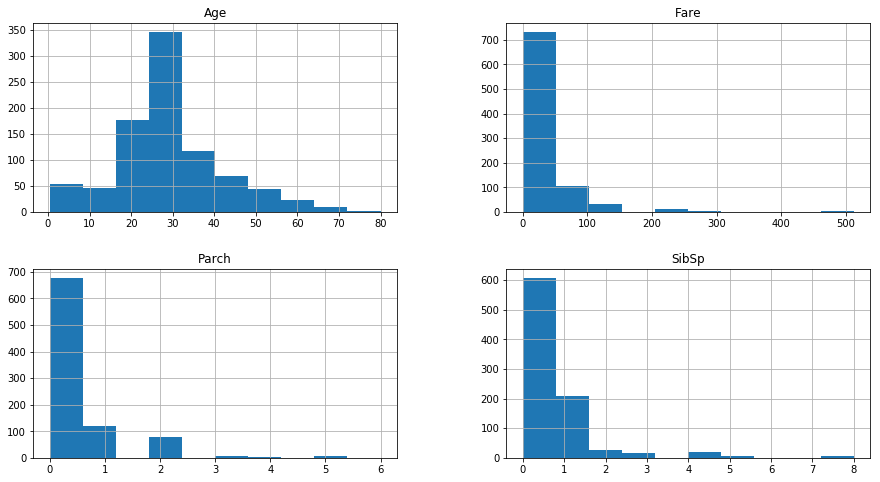

In [12]:
columns_for_histogram = titanic[['Age', 'SibSp','Parch','Fare']]
columns_for_histogram.hist(figsize=(15,8));

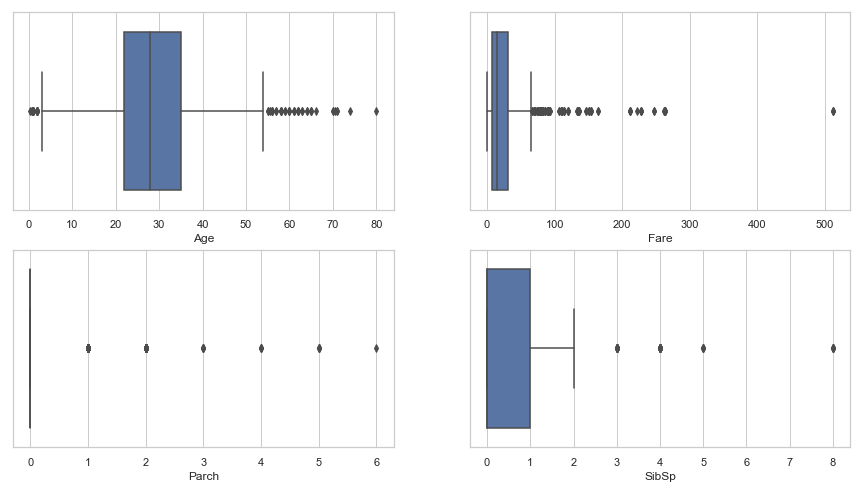

In [13]:
sns.set(style='whitegrid')
f, axes = plt.subplots(2,2, figsize=(15,8))
sns.boxplot(titanic['Age'], ax=axes[0,0])
sns.boxplot(titanic['Fare'], ax=axes[0,1])
sns.boxplot(titanic['Parch'], ax=axes[1,0])
sns.boxplot(titanic['SibSp'], ax=axes[1,1])

The histograms and boxplots for the numerical data all show a significant amount of right skew. The 'Age' histogram now looks different after having missing values imputed but the distribution seems similar. All features have quite a few outliers.

## Categorical Features:

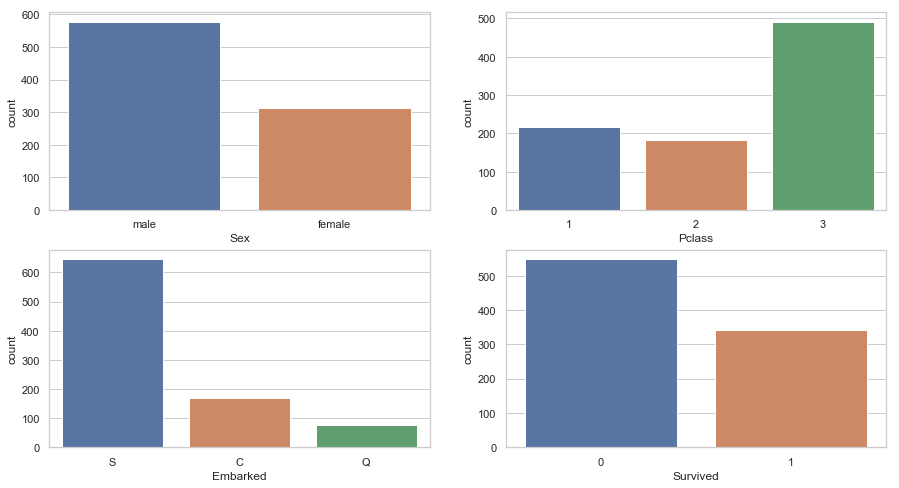

In [14]:
f, axes = plt.subplots(2,2, figsize=(15,8))
sns.countplot(titanic['Sex'], ax=axes[0,0])
sns.countplot(titanic['Pclass'], ax=axes[0,1])
sns.countplot(titanic['Embarked'], ax=axes[1,0])
sns.countplot(titanic['Survived'], ax=axes[1,1])

The number of passengers with a 3rd class ticket is roughly the same size as the number of passengers who did not survive. This could indicate a link but more analysis will need to be done first.

## Feature Interactions:

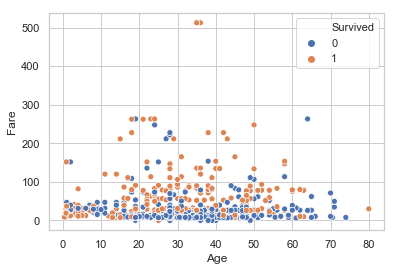

In [15]:
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=titanic);

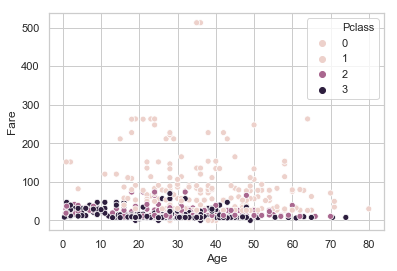

In [16]:
sns.scatterplot(x='Age', y='Fare', hue='Pclass', data=titanic);

There does not seem to be a trend between a passengers age and their fare/ticket class. However, it is clear their ticket class is lower the higher the fare and that those who payed a higher fare were more likely to survive.

In [17]:
# Creates a list of the column names without the column that is going to be predicted
features = list(titanicEncoded.columns[:-1])

# Stores the values for 'y' in a separate dataframe
y = titanicEncoded['Survived']

# Displays the correlations of all the features with 'Survived'
correlations = titanicEncoded[features].corrwith(y)
correlations.sort_values(inplace=True)
correlations

Male          -0.543351
Pclass        -0.338481
Southampton   -0.149683
Age           -0.064910
SibSp         -0.035322
Queenstown     0.003650
Parch          0.081629
Cherbourg      0.168240
Fare           0.257307
Female         0.543351
dtype: float64

In [18]:
titanicEncoded.corr()

,Age,SibSp,Parch,Fare,Pclass,Female,Male,Cherbourg,Queenstown,Southampton,Survived
Age,1.000000,-0.233296,-0.172482,0.096688,-0.339898,-0.081163,0.081163,0.030248,-0.031415,-0.006729,-0.064910
SibSp,-0.233296,1.000000,0.414838,0.159651,0.083081,0.114631,-0.114631,-0.059528,-0.026354,0.068734,-0.035322
Parch,-0.172482,0.414838,1.000000,0.216225,0.018443,0.245489,-0.245489,-0.011069,-0.081228,0.060814,0.081629
Fare,0.096688,0.159651,0.216225,1.000000,-0.549500,0.182333,-0.182333,0.269335,-0.117216,-0.162184,0.257307
Pclass,-0.339898,0.083081,0.018443,-0.549500,1.000000,-0.131900,0.131900,-0.243292,0.221009,0.074053,-0.338481
Female,-0.081163,0.114631,0.245489,0.182333,-0.131900,1.000000,-1.000000,0.082853,0.074115,-0.119224,0.543351
Male,0.081163,-0.114631,-0.245489,-0.182333,0.131900,-1.000000,1.000000,-0.082853,-0.074115,0.119224,-0.543351
Cherbourg,0.030248,-0.059528,-0.011069,0.269335,-0.243292,0.082853,-0.082853,1.000000,-0.148258,-0.782742,0.168240
Queenstown,-0.031415,-0.026354,-0.081228,-0.117216,0.221009,0.074115,-0.074115,-0.148258,1.000000,-0.499421,0.003650
Southampton,-0.006729,0.068734,0.060814,-0.162184,0.074053,-0.119224,0.119224,-0.782742,-0.499421,1.000000,-0.149683


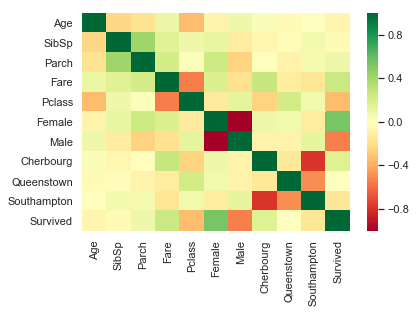

In [19]:
sns.heatmap(titanicEncoded.corr(), cmap="RdYlGn");

The heatmap indicates several features that correlate to some degree with having survived. The 'Male' column shows an inverse correlation with the survive column indicating that being male would make you less likely to survive. For the 'Female' column the opposite is true. What is interesting is that 'Pclass' and 'Fare' seem to show some correlation. They may be important features for the model as the earlier visualisations also indicated. 